In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer, recall_score, precision_score


In [ ]:
data = pd.read_csv("Titanic-Dataset.csv")
data = data.drop(['PassengerId', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Name','Age'], axis=1)


def diag_to_bin(gender):
    #gender (str) : lettre M ou B
    #return (int) : 1 ou 0 selon la valeur de gender
    if gender=="male":
        return 1
    else: #implicitement "B" sinon elif marche aussi
        return 0
    
diag_bin = data["Sex"].apply(diag_to_bin) #apply pour toutes les valeurs (https://saturncloud.io/blog/pandas-how-to-change-all-the-values-of-a-column/)
data["Sex"]= diag_bin



print(data.describe())

y = data["Survived"]
X = data
X_sd = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sd, y, test_size=0.2, random_state=42, stratify=y,shuffle=True) #stratify par y pour garder environ 37% de positifs (https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn)


def evaluation_modele(model, X_train, X_test, y_train, y_test, override="yes", w=0.8):
    if hasattr(model, 'predict_proba'): # Vérifier si le modèle supporte predict_proba
        y_test_proba = model.predict_proba(X_test)[:, 1] # Probabilités pour le test set
        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, drop_intermediate=False)
        roc_auc = roc_auc_score(y_test, y_test_proba)
        
        # Calculer l'index de Youden
        if override.lower() == "yes":
            youden_index = w*tpr - (1-w)*fpr
            youden_type = "pondéré"
        else:
            youden_index = tpr - fpr
            youden_type = "standard"
        
        # Trouver le seuil optimal
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        
        # Prédictions avec le seuil optimal
        y_test_pred = (y_test_proba >= optimal_threshold).astype(int)
        
        # Utiliser le même seuil optimal (calculé sur test)
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
        
        # Calculer le recall (TPR) avec le seuil optimal
        recall_optimal = recall_score(y_test, y_test_pred)
        
        print("Seuil optimal de Youden (" + youden_type + "): " + str(np.round(optimal_threshold, 4)))
        print("Recall obtenu avec ce seuil: " + str(np.round(recall_optimal, 4)))
    else:
        # Si le modèle ne supporte pas predict_proba, utiliser predict normal
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)

    conf_matrix = confusion_matrix(y_test, y_test_pred) # Matrice de confusion
    print(model)
    print(conf_matrix)
    
    print(classification_report(y_test, y_test_pred, target_names=['Y=0', 'Y=1']))
    
    return {'train_score': train_score,'test_score': test_score,'confusion_matrix': conf_matrix,'model': model} #Valeurs dans le dictionnaire

results = {} # Pour relier les résultats à un modèle choisi.

         Survived      Pclass         Sex       SibSp       Parch
count  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642    0.647587    0.523008    0.381594
std      0.486592    0.836071    0.477990    1.102743    0.806057
min      0.000000    1.000000    0.000000    0.000000    0.000000
25%      0.000000    2.000000    0.000000    0.000000    0.000000
50%      0.000000    3.000000    1.000000    0.000000    0.000000
75%      1.000000    3.000000    1.000000    1.000000    0.000000
max      1.000000    3.000000    1.000000    8.000000    6.000000


[1.78582626 1.42843117 0.82247195 0.56990073 0.39898787]


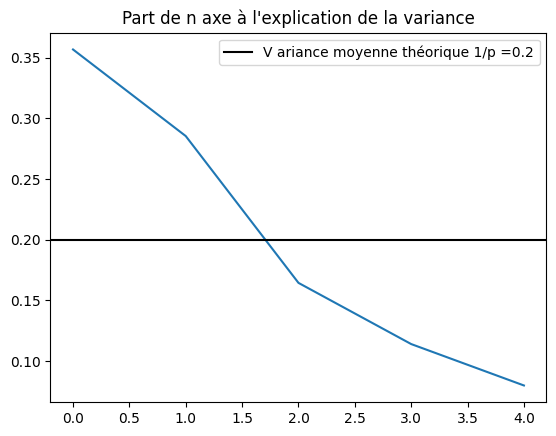

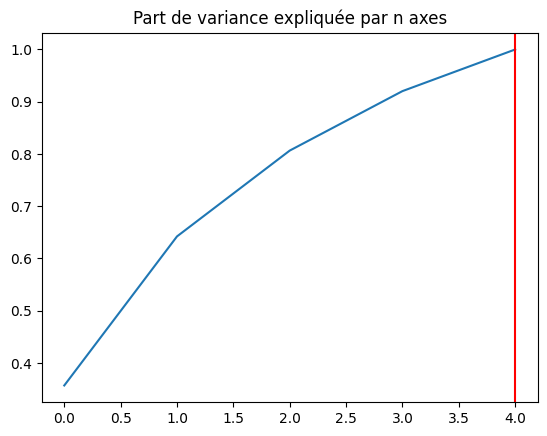

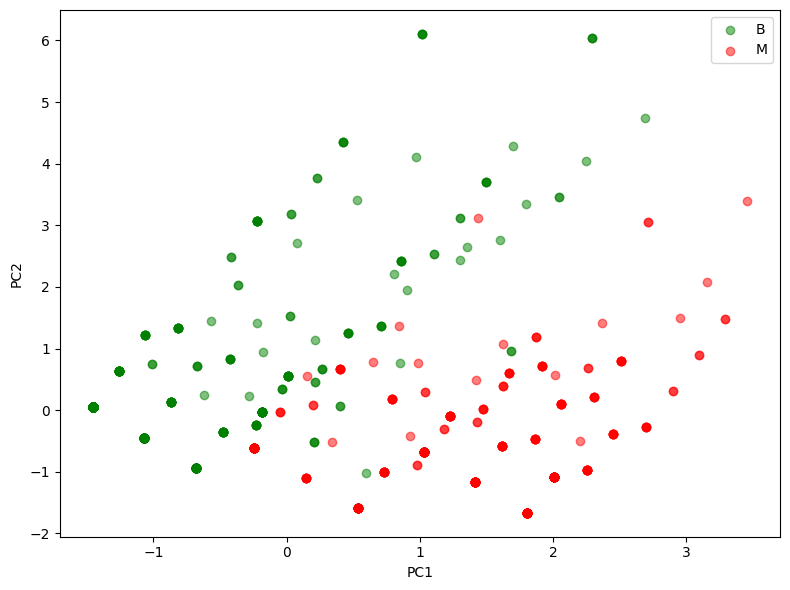

In [ ]:
#Réduction de dimensions (Inspiration TD1)

X_sd = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X_sd)

# Calcul des valeurs propres
print(pca.explained_variance_)

# Part de variance expliquee
pca.explained_variance_ / pca.explained_variance_.sum()
(pca.explained_variance_ / pca.explained_variance_.sum()).cumsum()

#Plot de la variance expliquée vs le nombre d'axes PCA.
plt.plot(pca.explained_variance_  / pca.explained_variance_.sum())
plt.axhline(1 / X_sd.shape[1], color='k',label="V ariance moyenne théorique 1/p ="+str(np.round((1 / X_sd.shape[1]),decimals=2)))
plt.title("Part de n axe à l'explication de la variance")
plt.legend()
plt.savefig('Part de n axe à l explication de la variance.png')
plt.show()

nb_dim_opti = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(nb_dim_opti, color='r',label="Nombre d'axe optimal pour expliquer 90% de la variance (="+str(nb_dim_opti)+")")
plt.title("Part de variance expliquée par n axes")
plt.savefig('Part de variance expliquée par n axes')
plt.show()



# On va maintenant projeter les patients sur les axes PC1 et PC2 afin de voir à quel point ces deux axes séparent les données
X_pca = pca.transform(X_sd)

# Créations de masques pour le scatter
mask_Y1 = (y == 1)
mask_Y0 = (y == 0)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[mask_Y0, 0], X_pca[mask_Y0, 1],color='green', alpha=0.5, label='Y=0')
plt.scatter(X_pca[mask_Y1, 0], X_pca[mask_Y1, 1],color='red', alpha=0.5, label='Y=1')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig("Projection des patients sur le plan des deux premiers axes PCA.png")
plt.show()

In [7]:
#LDA

lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)
results['LDA'] = evaluation_modele(lda, X_train, X_test, y_train, y_test)


#QDA

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
results['QDA'] = evaluation_modele(qda,X_train, X_test, y_train, y_test)

#Logistique
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
logit.fit(X_train, y_train)
results['Logistic Regression'] = evaluation_modele(
    logit, X_train, X_test, y_train, y_test
)

#KNN
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25]}
knn_base = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_base, param_grid_knn, cv=5, scoring='recall', n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)
print("Meilleur k: "+ str(knn_grid.best_params_['n_neighbors']))
print("Score validation croisée: " + str(knn_grid.best_score_))
results['KNN'] = evaluation_modele(knn_grid.best_estimator_,X_train, X_test, y_train, y_test)


Seuil optimal de Youden (pondéré): 1.0
Recall obtenu avec ce seuil: 1.0
LinearDiscriminantAnalysis()
[[110   0]
 [  0  69]]
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       110
   Malignant       1.00      1.00      1.00        69

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179

Seuil optimal de Youden (pondéré): 1.0
Recall obtenu avec ce seuil: 1.0


c:\Users\valen\anaconda3\envs\py38\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()
[[110   0]
 [  0  69]]
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       110
   Malignant       1.00      1.00      1.00        69

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179

Seuil optimal de Youden (pondéré): 0.983
Recall obtenu avec ce seuil: 1.0
LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
[[110   0]
 [  0  69]]
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       110
   Malignant       1.00      1.00      1.00        69

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Meilleur k: 11
Score validation croisée: 0.996363636363636

In [9]:
#RFC
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_grid = GridSearchCV(rf_base, param_grid_rf, cv=5, scoring='accuracy',n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
print("Meilleur k: "+ str(rf_grid.best_params_))
print("Score validation croisée: " + str(rf_grid.best_score_))
results['Random Forest'] = evaluation_modele(rf_grid.best_estimator_, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Meilleur k: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Score validation croisée: 1.0
Seuil optimal de Youden (pondéré): 0.96
Recall obtenu avec ce seuil: 1.0
RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)
[[110   0]
 [  0  69]]
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       110
   Malignant       1.00      1.00      1.00        69

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



In [12]:
# Stockage des features_importance du Random Forest en dictionnaire pour le wordcloud final
features_importance_rf = dict(zip(X.columns, rf_grid.best_estimator_.feature_importances_))

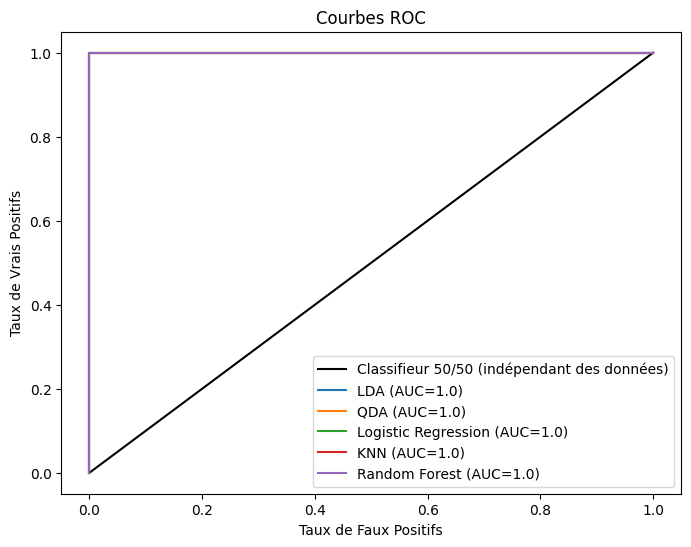

AUC par algorithme : 
LDA    1.0
QDA    1.0
Logistic Regression    1.0
KNN    1.0
Random Forest    1.0
VALIDATION CROISÉE (5 folds):
LDA: Accuracy=1.0+-0.0, ROC-AUC=1.0+-0.0
QDA: Accuracy=1.0+-0.0, ROC-AUC=1.0+-0.0
Logistic Regression: Accuracy=1.0+-0.0, ROC-AUC=1.0+-0.0
KNN: Accuracy=0.9933+-0.0083, ROC-AUC=0.9999+-0.0002
Random Forest: Accuracy=1.0+-0.0, ROC-AUC=1.0+-0.0


In [11]:
#Comparaison : 

# Courbes ROC

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color="k",label='Classifieur 50/50 (indépendant des données)')

for name, res in results.items():
    model = res['model']
    y_pred = model.predict_proba(X_test)[:, 1]
    faux_pos, vrai_pos, thresholds = roc_curve(y_test, y_pred)
    plt.plot(faux_pos, vrai_pos, label = name + " (AUC=" + str(np.round(roc_auc_score(y_test, y_pred), 3)) + ")")

plt.title("Courbes ROC")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.legend()
plt.savefig('Courbes ROC.png')
plt.show()

# AUC 
print("AUC par algorithme : ")
for name, res in results.items():
    model = res['model']
    y_pred = model.predict_proba(X_test)[:, 1]
    print(name +"    "+ str(roc_auc_score(y_test, y_pred)))

# Validation croisée des modèles
print("VALIDATION CROISÉE (5 folds):")
for name, res in results.items():
    model = res['model']
    # Réutiliser les modèles déjà entraînés avec leurs paramètres
    if name == 'KNN':
        cv_model = KNeighborsClassifier(**knn_grid.best_params_)
    elif name == 'Random Forest':
        cv_model = RandomForestClassifier(random_state=42, class_weight='balanced', **rf_grid.best_params_)
    else:
        cv_model = model
    
    acc_scores = cross_val_score(cv_model, X_sd, y, cv=5, scoring='accuracy', n_jobs=-1)
    roc_scores = cross_val_score(cv_model, X_sd, y, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1)
    print(name + ": Accuracy=" + str(round(acc_scores.mean(), 4)) + "+-" + str(round(acc_scores.std(), 4)) + ", ROC-AUC=" + str(round(roc_scores.mean(), 4)) + "+-" + str(round(roc_scores.std(), 4)))
